# Tutorial Q1 - Qubit rotation

This tutorial demonstrates the very basic working principles of openqml for qubit-based backends. We only look at a single quantum function consisting of a single-qubit circuit. The task is to optimize two rotation gates in order to flip the qubit from state $|0\rangle$ to state $|1\rangle $. 

## Imports

First we need to import openqml, as well as openqml's version of numpy. This allows us to automatically compute gradients for functions that manipulate numpy arrays, including quantum functions. We call this numpy version `onp` in case we need it alongside the original version.

In [1]:
import openqml as qm
from openqml import numpy as np
from openqml.optimize import GradientDescentOptimizer, AdagradOptimizer

12:49:58 WARNING No OpenQML configuration file found.


Next, create a projecq simulator as a "device" to run the quantum node. We only need a single quantum wire.

In [2]:
dev1 = qm.device('projectq.simulator', wires=1)

## Quantum function

We define a quantum function called "circuit". 

In [3]:
@qm.qfunc(dev1)
def circuit(variables):
    
    qm.RX(variables[0], [0])
    qm.RY(variables[1], [0])
    
    return qm.expectation.PauliZ(0)

This function uses openqml to run the following quantum circuit:

<img src="figures/rotation_circuit.png">

Starting with a qubit in the ground state, 

$$ |0\rangle = \begin{pmatrix}1 \\ 0 \end{pmatrix}, $$

we first rotate the qubit around the x-axis by 
$$R_x(w_0) = e^{-iw_0 X /2} = 
\begin{pmatrix} \cos \frac{w_0}{2} &  -i \sin \frac{w_0}{2} \\  
                -i \sin \frac{w_0}{2} &  \cos \frac{w_0}{2} 
\end{pmatrix}, $$ 
               
and then around the y-axis by 
$$ R_y(w_1) = e^{-i w_1 Y/2} = 
\begin{pmatrix} \cos \frac{w_1}{2} &  - \sin \frac{w_1}{2} \\  
                \sin \frac{w_1}{2} &  \cos \frac{w_1}{2} 
\end{pmatrix}. $$ 

After these operations the qubit is in the state

$$ | \psi \rangle = R_y(w_0) R_x(w_1) | 0 \rangle $$

Finally, we measure the expectation $ \langle \psi | Z | \psi \rangle $ of the Pauli-Z operator 
$$Z = 
\begin{pmatrix} 1 &  0 \\  
                0 & -1 
\end{pmatrix}. $$ 


Depending on the circuit parameters $w_1$ and $w_2$, the output expectation lies between $1$ (if $| \psi \rangle = | 0  \rangle $) and $-1$ (if $| \psi \rangle = | 1  \rangle $).

## Objective

Next, we define a cost. Here, the cost is directly the expectation of the PauliZ measurement, so that the cost is trivially the output of the circuit.

In [4]:
def objective(variables):
    return circuit(variables)

With this objective, the optimization procedure is supposed to find the weights that rotate the qubit from the ground state 

 <img src="figures/bloch_before.png" width="250"> 
 
 to the excited state
 
 <img src="figures/bloch_after.png" width="250">
 
 The rotation gates give the optimization landscape a trigonometric shape with four global minima and five global maxima. *Note: To run the following cell you need the matplotlib library.*

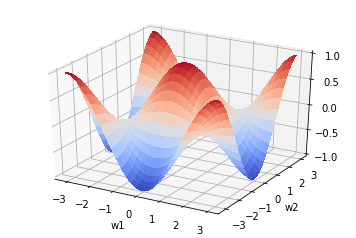

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig = plt.figure(figsize = (6, 4))
ax = fig.gca(projection='3d')

X = np.arange(-3.1, 3.1, 0.1)
Y = np.arange(-3.1, 3.1, 0.1)
length = len(X)
xx, yy = np.meshgrid(X, Y)
Z = np.array([[objective([x, y]) for x in X] for y in Y]).reshape(length, length)
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, antialiased=False)

ax.set_xlabel("w1")
ax.set_ylabel("w2")
ax.zaxis.set_major_locator(LinearLocator(5))

plt.show()

## Optimization

The initial values of the x- and y-rotation parameters $w_1, w_2$ are set to near-zero. This corresponds to identity gates, in other words, the circuit leaves the qubit in the ground state. *Note that at zero exactly the gradient vanishes and the optimization algorithm will not descent from the maximum.*

In [25]:
variables_init = np.array([0.01, 0.01])

print('Initial rotation angles: {} '.format(variables_init))

Initial rotation angles: [0.01 0.01] 


The value of the objective at the initial point is close to $1$.

In [18]:
objective(variables_init)

0.9999000033332889

We choose a simple Gradient Descent Optimizer and update the weights for 10 steps. The final parameters correspond to a $Z$ expectation of nearly $-1$, which means that the qubit is flipped.

In [22]:
o = GradientDescentOptimizer(0.5)

weights_gd = []
variables = variables_init
for it in range(100):
    weights = o.step(objective, variables)

    weights_gd.append(weights)
    if it % 5 == 0:
        print('Objective after step {:5d}: {: .7f}'.format(it, objective(weights)) )

print()
print('\nOptimized rotation angles: {}'.format(variables))

Objective after step     0:  0.9997750
Objective after step     5:  0.9997750
Objective after step    10:  0.9997750
Objective after step    15:  0.9997750
Objective after step    20:  0.9997750
Objective after step    25:  0.9997750
Objective after step    30:  0.9997750
Objective after step    35:  0.9997750
Objective after step    40:  0.9997750
Objective after step    45:  0.9997750
Objective after step    50:  0.9997750
Objective after step    55:  0.9997750
Objective after step    60:  0.9997750
Objective after step    65:  0.9997750
Objective after step    70:  0.9997750
Objective after step    75:  0.9997750
Objective after step    80:  0.9997750
Objective after step    85:  0.9997750
Objective after step    90:  0.9997750
Objective after step    95:  0.9997750

Optimized rotation angles: [-0.01  0.01]


Starting at a different offset, we train another optimizer called Adagrad, which improves on gradient descent.

In [24]:
variables_init = np.array([-0.01, 0.01])
print('Initial rotation angles: {} \n'.format(variables_init))

o = AdagradOptimizer(0.5)

weights_adam = []
variables = variables_init
for it in range(100):
    weights = o.step(objective, variables)
    
    weights_adam.append(weights)
    if it % 5 == 0:
        print('Objective after step {:5d}: {: .7f}'.format(it, objective(weights)) )

print('\nOptimized rotation angles: {}'.format(variables))

Initial rotation angles: [-0.01  0.01] 

Objective after step     0:  0.7617043
Objective after step     5:  0.9548480
Objective after step    10:  0.9743797
Objective after step    15:  0.9818856
Objective after step    20:  0.9858801
Objective after step    25:  0.9883689
Objective after step    30:  0.9900725
Objective after step    35:  0.9913142
Objective after step    40:  0.9922608
Objective after step    45:  0.9930072
Objective after step    50:  0.9936114
Objective after step    55:  0.9941110
Objective after step    60:  0.9945313
Objective after step    65:  0.9948899
Objective after step    70:  0.9951998
Objective after step    75:  0.9954703
Objective after step    80:  0.9957086
Objective after step    85:  0.9959203
Objective after step    90:  0.9961095
Objective after step    95:  0.9962798

Optimized rotation angles: [-0.01  0.01]


Adagrad and gradient descent find the same minimum, and, since neither has information on second order derivatives, both take a detour through a saddle point. However, Adagrad takes considerably fewer steps.

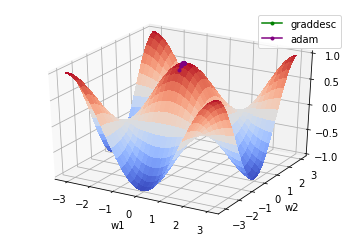

In [37]:
fig = plt.figure(figsize = (6, 4))
ax = fig.gca(projection='3d')

X = np.arange(-3.1, 3.1, 0.1)
Y = np.arange(-3.1, 3.1, 0.1)
length = len(X)
xx, yy = np.meshgrid(X, Y)
Z = np.array([[objective([x, y]) for x in X] for y in Y]).reshape(length, length)
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, antialiased=False)

path_z = [objective(weights)+0.001 for weights in weights_gd]
path_x = [w[0] for w in weights_gd]
path_y = [w[1] for w in weights_gd]
ax.plot(path_x, path_y, path_z, c='green', marker='.', label="graddesc")

path_z = [objective(weights)+0.001 for weights in weights_adam]
path_x = [w[0] for w in weights_adam]
path_y = [w[1] for w in weights_adam]
ax.plot(path_x, path_y, path_z, c='purple', marker='.', label="adam")

ax.set_xlabel("w1")
ax.set_ylabel("w2")
ax.zaxis.set_major_locator(LinearLocator(5))

plt.legend()
plt.show()